In [5]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counter intuitive

### MobileNet V2 Trained by Google

In [6]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [67]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

In [69]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=IMG_SIZE)

Found 16000 files belonging to 8 classes.
Found 16000 files belonging to 8 classes.


In [70]:
class_names = train_dataset.class_names
print(class_names)

['chan_down', 'chan_up', 'doub_bot', 'doub_top', 'hs', 'tri', 'wed_down', 'wed_up']


In [71]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

<function keras.src.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [72]:
## Using buffered prefetching
# AUTOTUNE = tf.data.AUTOTUNE
# 
# train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [74]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [79]:
# Unfreeze this to train
base_model.trainable = False

# Adding a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

# Add a dense layer to convert it to a single prediction per image
# Test relu, leaky_relu, and sigmoid
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [85]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [92]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [91]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 114ms/step - accuracy: 0.1298 - loss: 2.1478


In [86]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 193ms/step - accuracy: 0.1346 - loss: 2.4651 - val_accuracy: 0.1216 - val_loss: 2.1625
Epoch 2/10
167/500 ━━━━━━━━━━━━━━━━━━━━ 36s 109ms/step - accuracy: 0.1255 - loss: 2.3450

KeyboardInterrupt: 

In [ ]:
class_names = train_dataset.class_names

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

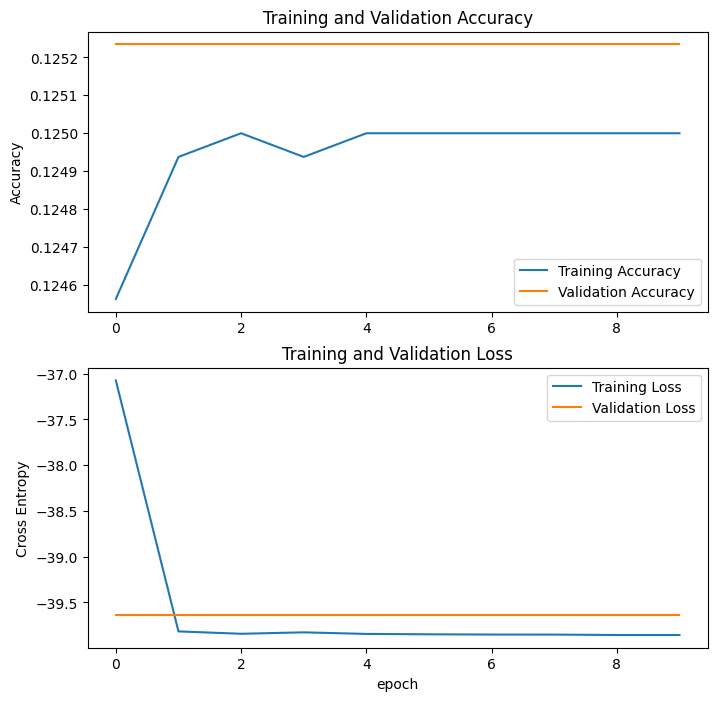

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [158]:
base_model.trainable = True

In [159]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [161]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='binary_accuracy')])

In [162]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 165s 317ms/step - binary_accuracy: 0.1238 - loss: -39.1204 - val_binary_accuracy: 0.1252 - val_loss: -39.6249
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 298ms/step - binary_accuracy: 0.1225 - loss: -39.9846 - val_binary_accuracy: 0.1252 - val_loss: -39.5970
Epoch 13/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 298ms/step - binary_accuracy: 0.1227 - loss: -40.0220 - val_binary_accuracy: 0.1252 - val_loss: -39.5743
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 292ms/step - binary_accuracy: 0.1227 - loss: -40.0781 - val_binary_accuracy: 0.1252 - val_loss: -39.6309
Epoch 15/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 289ms/step - binary_accuracy: 0.1227 - loss: -40.0804 - val_binary_accuracy: 0.1252 - val_loss: -39.6325
Epoch 16/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 289ms/step - binary_accuracy: 0.1226 - loss: -40.0840 - val_binary_accuracy: 0.1252 - val_loss: -39.6343
Epoch 17/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 293ms/step - binary_accuracy: 0.1227 - loss: -40

In [165]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

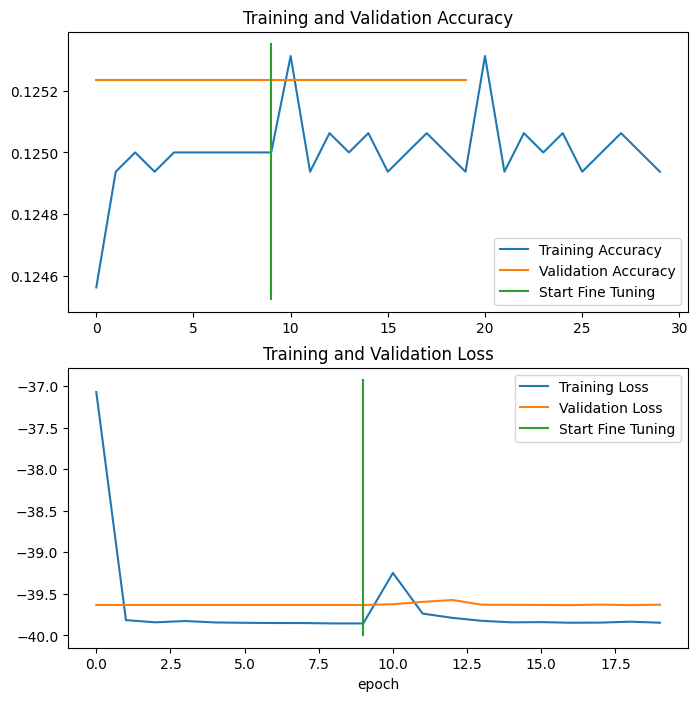

In [166]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 3 7 3 0 4 1 3 0 3 5 6 2 7 7 7 3 4 2 5 2 6 3 6 6 2 1 6 4 0 0]


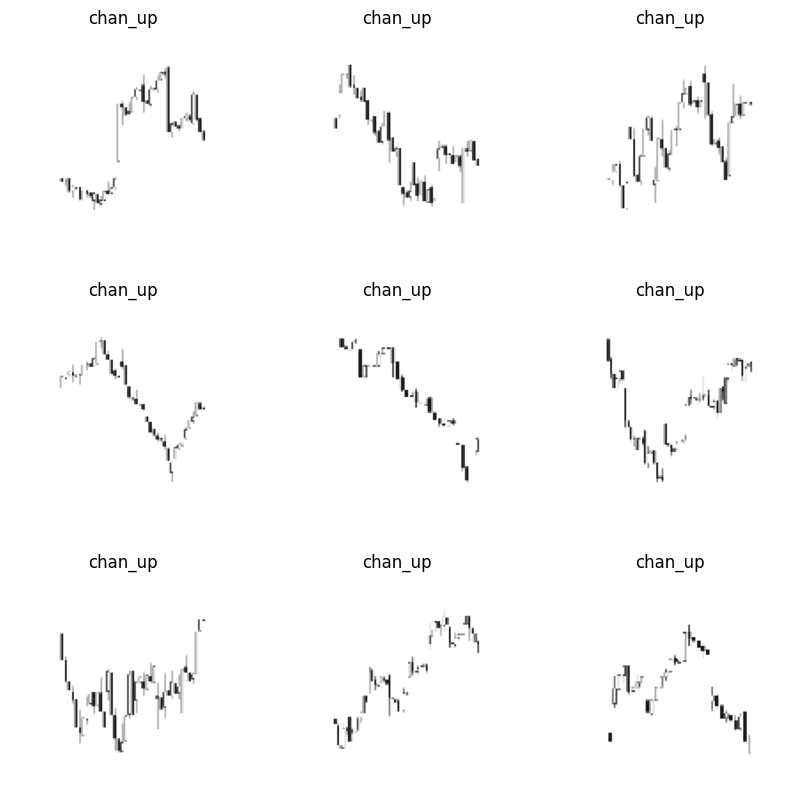

In [167]:
class_names = train_dataset.class_names

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")